In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy.physics.wigner import wigner_3j,wigner_6j
import lmfit
from lmfit import Parameters,minimize
import copy

In [2]:
plt.rcParams.update({'font.size': 10})
save=r'C:\Users\Arian\Dropbox (Hutzler Lab)\HutzlerLabShared\Personal\ArianJadbabaie\Thesis\Ch4\\'
import seaborn as sns
sns.set()
sns.set_palette('bright')
sns.set_style('white')

In [3]:
def kronecker(a,b):         # Kronecker delta function
    if a==b:
        return 1
    else:
        return 0

def b2a_matrix(a,b,S=1/2):
    if not kronecker(a['K'],b['K'])*kronecker(a['J'],b['J'])*kronecker(a['F'],b['F'])*kronecker(a['M'],b['M']):
        return 0
    else:
        if 'F1' in b.keys():
            if not kronecker(a['F1'],b['F1']):
                return 0
        return (-1)**(b['N']-S+a['P'])*np.sqrt(2*b['N']+1)*wigner_3j(a['J'],S,b['N'],a['P'],-a['Sigma'],-a['K'])
    
def convert_abBJ(input_qnumbers,output_qnumbers,S=1/2):
    input_keys = list(input_qnumbers)
    output_keys = list(output_qnumbers)
    input_size = len(input_qnumbers[input_keys[0]])
    output_size = len(output_qnumbers[output_keys[0]])
    basis_matrix = np.zeros((output_size,input_size))
    for i in range(output_size):
        for j in range(input_size):
            if 'N' in input_keys: #Convert case (b) to (a)
                a_qnumbers = {q:output_qnumbers[q][i] for q in output_keys}
                b_qnumbers = {q:input_qnumbers[q][j] for q in input_keys}
            else:
                b_qnumbers = {q:output_qnumbers[q][i] for q in output_keys}
                a_qnumbers = {q:input_qnumbers[q][j] for q in input_keys}
            basis_matrix[i,j] = b2a_matrix(a_qnumbers,b_qnumbers,S=S)
    return basis_matrix

def q_numbers_even_bBJ(N_range,K_mag,S=1/2,I_list=[0,1/2],M_values='all',M_range=[]):
    IM=I_list[0]
    iH = I_list[-1]
    Nmin,Nmax=N_range[0],N_range[-1]
    K_mag = abs(K_mag)
    if Nmin<K_mag:
        print('Nmin must be >= |K|')
        Nmin=abs(K_mag)
    q_str = ['K','N','J','F','M']
    I = max(IM,iH)
    q_numbers = {}
    for q in q_str:
        q_numbers[q] = []
    for N in np.arange(Nmin,Nmax+1,1):
        for J in np.arange(abs(N-S),abs(N+S)+1,1):
            for F in np.arange(abs(J-I),abs(J+I)+1,1):
                if M_values=='none':
                    for K in {True:[0], False:[-K_mag,K_mag]}[K_mag==0]:
                        M=abs(F)%1
                        values = [K,N,J,F,M]
                        for q,val in zip(q_str,values):
                            q_numbers[q].append(val+0)    #looks weird but adding 0 converts -0 to 0
                else:
                    if M_values=='all' or M_values=='custom':
                        Mmin = -F
                    elif M_values=='pos':
                        Mmin = abs(F) % 1
                    for M in np.arange(Mmin,F+1,1):
                        if (M_values=='custom' and M in M_range) or (M_values=='all') or (M_values=='pos'):
                            for K in {True:[0], False:[-K_mag,K_mag]}[K_mag==0]:
                                values = [K,N,J,F,M]
                                for q,val in zip(q_str,values):
                                    q_numbers[q].append(val+0)    #looks weird but adding 0 converts -0 to 0
                        elif M_values=='custom' and M not in M_range:
                            continue
    return q_numbers

def q_numbers_even_aBJ(N_range,K_mag=1,S=1/2,I_list=[0,1/2],M_values='all',P_values=[1/2],M_range=[]):
    IM=I_list[0]
    iH = I_list[-1]
    Nmin,Nmax=N_range[0],N_range[-1]
    Jmin = abs(Nmin-S)
    Jmax = abs(Nmax+S)
    K_mag = abs(K_mag)
    if Nmin<K_mag:
        print('Nmin must be >= |K|')
        Nmin=abs(K_mag)
    q_str = ['K','Sigma','P','J','F','M']
    q_numbers = {}
    for q in q_str:
        q_numbers[q] = []
    I = max(IM,iH)
    for J in np.arange(Jmin,Jmax+1,1):
        for F in np.arange(abs(J-I),abs(J+I)+1,1):
            if M_values=='none':
                for Sigma in np.arange(-abs(S),abs(S)+1,1):
                    for K in {True:[0], False:[-K_mag,K_mag]}[K_mag==0]:
                        P=K+Sigma
                        if abs(P) not in P_values:
                            continue
                        elif J < abs(P):
                            continue
                        else:
                            M=abs(F)%1
                            values = [K,Sigma,P,J,F,M]
                        for q,val in zip(q_str,values):
                            q_numbers[q].append(val+0)    #looks weird but adding 0 converts -0 to 0
            else:
                if M_values=='all' or M_values=='custom':
                    Mmin = -F
                elif M_values=='pos':
                    Mmin = abs(F) % 1
                for M in np.arange(Mmin,F+1,1):
                    if (M_values=='custom' and M in M_range) or (M_values=='all') or (M_values=='pos'):
                        for Sigma in np.arange(-abs(S),abs(S)+1,1):
                            for K in {True:[0], False:[-K_mag,K_mag]}[K_mag==0]:
                                P=K+Sigma
                                if abs(P) not in P_values:
                                    continue
                                elif J < abs(P):
                                    continue
                                else:
                                    values = [K,Sigma,P,J,F,M]
                                for q,val in zip(q_str,values):
                                    q_numbers[q].append(val+0)    #looks weird but adding 0 converts -0 to 0
                    elif M_values=='custom' and M not in M_range:
                        continue
    return q_numbers

def write_state(vector,qn,case):
    for index in np.nonzero(vector)[0]:
        v={q:qn[q][index] for q in qn}
        coeff = vector[index]
        if case == 'bBS':
            print(' {} |K={},N={},G={},F1={},F={},M={}> \n'.format(coeff,v['K'],v['N'],v['G'],v['F1'],v['F'],v['M']))
        elif case == 'bBJ':
            print(' {} |K={},N={},J={},F={},M={}> \n'.format(coeff,v['K'],v['N'],v['J'],v['F'],v['M']))
        elif case == 'aBJ':
            print(' {} |K={},\u03A3={},P={},J={},F={},M={}> \n'.format(coeff,v['K'],v['Sigma'],v['P'],v['J'],v['F'],v['M']))

In [4]:
def q_numbers_A010(N_range,J,l=1,L=1,Sigma=1/2,P_values=[1/2,3/2,5/2],Omega_values=[1/2,3/2]):
    q_str = ['Lambda','l','Sigma','K','Omega','P','J']
    q_numbers = {}
    for q in q_str:
        q_numbers[q] = []
    for _L in [-L,L]:
        for _l in [-l,l]:
            K = _L+_l
            for _S in [-Sigma, Sigma]:
                Omega = _S+_L
                if abs(Omega) not in Omega_values:
                    continue
                P= _L+_l+_S
                if abs(P) not in P_values:
                    continue
                elif J < abs(P):
                    continue
                else:
                    values = [_L,_l,_S,K,Omega,P,J]
                    for q,val in zip(q_str,values):
                            q_numbers[q].append(val+0)
    return q_numbers

There are two papers with effective Hamiltonians.
Earlier is the SrOH paper:
https://aip.scitation.org/doi/10.1063/1.468171

And later on is the CaOH paper:
https://aip.scitation.org/doi/10.1063/1.468643

The CaOH result has gK

In [5]:
params_A010 ={
    'Tev': 16360.3890,
    'A': 67.0951,
    'ADdelt': 0.1232e-3,
    'ADsig': 0.140e-2,
    'AH': -0.140e-6,
    'ew2': -36.2634,
    'eDw2': 0.741e-3,
    'gK': 0.5937,
    'Bdelt': 0.3402609,
    'Bsig': 0.3402123,
    'Ddelt': 0.3976e-6,
    'Dsig': 0.399e-6,
    'gam': 0.02617,
    'gamD': -0.119e-4,
    'pe': -0.04472,
    'qe': -0.3072e-3,
    'qv': -0.6978e-3,
    'eps': -0.099,
}

def CaOH_A010(J,ef_parity,params):
    n=4
    H = np.zeros((n,n))
    z=(J+1/2)**2
    p=params
    
    Tev = p['Tev']
    gK = p['gK']
    eps = p['eps']
    A = p['A']
    ADd = p['ADdelt']
    ADs = p['ADsig']
    AH = p['AH']
    ew2 = p['ew2']
    eDw2 = p['eDw2']
    Bd = p['Bdelt']
    Bs = p['Bsig']
    Dd = p['Ddelt']
    Ds = p['Dsig']
    g = p['gam']
    gD = p['gamD']
    pe = p['pe']
    qe = p['qe']
    qv = p['qv']
    
    if J>3/2:
        H[0,0] = Tev + 2*gK - 3/4*eps*ew2 + 1/2*A*(1-3/4*eps**2) + (Bd + 1/2*ADd)*(z-6) - (Dd - 1/2*AH*0)*(z**2 - 11*z + 32) - 1/2*g - 0*gD*(z-5)
        H[0,1] = -(Bd - 1/2*g)*(z-4)**(1/2) + 2*Dd*(z-4)**(3/2) + 0*1/2*gD*(z-3)*(z-4)**(1/2)
        H[0,2] = 1/2*qv*(z**2 - 5*z + 4)**(1/2)
        H[0,3] = ef_parity*1/2*qe*(z**2 - 5*z + 4)**(1/2)
        H[1:,0] = H[0,1:]
    if J>1/2:
        H[1,1] = Tev + 2*gK - 3/4*eps*ew2 - 1/2*A*(1-3/4*eps**2) + (Bd - 1/2*ADd)*(z-2) - (Dd + 1/2*AH*0)*z*(z-3) - 1/2*g - 0*gD*(z-3)
        H[1,2] = (ef_parity*1/2*qe*z**(1/2) - qv)*(z-1)**(1/2) #Ambiguity on this term between SrOH and CaOH
        H[1,3] = (-ef_parity*1/2*(pe + 2*qe) + 1/2*qv*z**(1/2))*(z-1)**(1/2)
        H[2:,1] = H[1,2:]
    H[2,2] = Tev - 1/4*eps*ew2 + 1/2*A*(1-1/4*eps**2) + (Bs + 1/2*ADs)*z - (Ds - 1/2*AH)*(z**2 + z) - ef_parity*eDw2*z**(1/2) - 1/2*g - gD*z
    H[2,3] = ef_parity*ew2 - (Bs - 1/2*g)*z**(1/2) + 2*Ds*z**(3/2) + ef_parity*eDw2*z + 1/2*gD*(z+1)*z**(1/2)
    H[3,2] = H[2,3]
    H[3,3] = Tev - 1/4*eps*ew2 - 1/2*A*(1-1/4*eps**2) + (Bs - 1/2*ADs)*z - (Ds + 1/2*AH)*(z**2 + z) - ef_parity*eDw2*z**(1/2) - 1/2*g - gD*z
    
    
    if J == 1/2:
        H0 = H[2:,2:]
#         print(H0)
        return H0
    elif J == 3/2:
        H0 = H[1:,1:]
#         print(H0)
        return H0
    else:
#         print(H)
        return H

def A010(J,parity,params):
    n=4
    H = np.zeros((n,n))
    z=(J+1/2)**2 - 1
    p=params
    
    w2 = p['w2']
    gK = p['gK']
    e = p['eps']
    A = p['A']
    w2 = p['w2']
    ew2 = p['ew2']
    eDw2 = p['eDw2']
    B = p['B']
    pe = p['pe']
    qe = p['qe']
    qv = p['qv']
    pv = p['pv']
    gm = p['gamma']
    
    if J>3/2:
        H[0,0] = 2*w2 + 2*gK - 3*(ew2)**2/(2*(2*w2 - A)) + 1/2*A + B*(z - 4) - D*(z**2 - 7*z + 13)
        H[0,1] = -(z - 3)**(1/2)*(B - 1/2*gm - 2*D*(z-2))
        H[0,2] = 1/2*qv*(z*(z - 1))**(1/2)
        H[0,3] = parity*(-1)**(J-1/2)*1/2*qe*(z*(z-3))**(1/2)
        H[1:,0] = H[0,1:]
    if J>1/2:
        H[1,1] = 2*w2 + 2*gK - 3*(ew2)**2/(2*(2*w2 + A)) - 1/2*A - gm + B*z - D*(z**2+z-3)
        H[1,2] = parity*(-1)**(J-1/2)*qe*(z*(z+1))**(1/2) + 1/2*(pv+ 2*qv)*z**(1/2)
        H[1,3] = -parity*(-1)**(J-1/2) * 1/2*(pe + 2*qe)*z**(1/2) - 1/2*qv*(z*(z+1))**(1/2)
        if depert:
            H[1,3]=0
        H[2:,1] = H[1,2:]
    H[2,2] = 2*w2 - (ew2)**2/(2*(2*w2 - A)) + 1/2*A + parity*(-1)**(J-1/2)*eDw2 * (J+1/2) + B*(z+2) - D*(z**2 + 5*z + 5)
    H[2,3] = -(z+1)**(1/2)*(B - gm/2 -2*D*(z+2)) - parity*(-1)**(J-1/2)*ew2*(1+((ew2)**2*(8*w2**2 - 6*A**2))/(4*(4*w2**2-A**2))) - parity*(-1)**(J-1/2)*eDw2*(z+2)
    H[3,2] = H[2,3]
    H[3,3] = 2*w2 - (ew2)**2/(2*(2*w2 + A)) - 1/2*A - gm + parity*(-1)**(J-1/2) + B*(z+2) - D*(z**2 + 5*z + 5)
    
    
    if J == 1/2:
        H0 = H[2:,2:]
#         print(H0)
        return H0
    elif J == 3/2:
        H0 = H[1:,1:]
#         print(H0)
        return H0
    else:
#         print(H)
        return H

There is also the effective Hamiltonian form in the Brown computational molecular physics chapter. Let's use that, it's specifically for large spin-orbit

In [147]:
def A010(J,parity,params,depert=False):
    n=4
    H = np.zeros((n,n))
    z=(J+1/2)**2 - 1
    p=params
    w2 = p['w2']
    gK = p['gK']
    A = p['A']
    if 'e' in params:
        e = p['e']
        ew2 = e*w2
    elif 'ew2' in params:
        ew2 = p['ew2']
    eDw2 = p['eDw2']
    B = p['B']
    D = p['D']
    pe = p['pe']
    qe = pe*B/A
    pv = p['pv']
    qv = pv*B/A
    gm = p['gamma']
    T0 = p['T0']
    
    if depert:
        pe=0
        qe=0
        pv=0
        qv=0
    ell=1
    ecorr = 1+1/4*ew2**2*((8*w2**2-6*A**2)/(4*w2**2-A**2)**2)
    if J>3/2:
        H[0,0] = T0+w2 + 2*gK - 3*(ew2)**2/(2*(2*w2 - A)) + 1/2*A + B*(z - 4) - D*(z**2 - 7*z + 13)
        H[0,1] = -(z - 3)**(1/2)*(B - 1/2*gm - 2*D*(z-2))
        H[0,2] = -1/2*qv*(z*(z - 1))**(1/2)
        H[0,3] = parity*(-1)**(J-1/2-ell)*1/2*qe*(z*(z-3))**(1/2)
#         if depert:
#             H[0,3] = 0
        H[1:,0] = H[0,1:]
    if J>1/2:
        H[1,1] = T0+w2 + 2*gK - 3*(ew2)**2/(2*(2*w2 + A)) - 1/2*A - gm + B*z - D*(z**2+z-3)
        H[1,2] = parity*(-1)**(J-1/2-ell)*qe*(z*(z+1))**(1/2) + 1/2*(pv+ 2*qv)*z**(1/2)
        H[1,3] = -parity*(-1)**(J-1/2-ell) * 1/2*(pe + 2*qe)*z**(1/2) - 1/2*qv*(z*(z+1))**(1/2)
#         if depert:
#             H[1,3]=0
        H[2:,1] = H[1,2:]
    H[2,2] = T0+w2 - (ew2)**2/(2*(2*w2 - A)) + 1/2*A + parity*(-1)**(J-1/2-ell)*eDw2 * (J+1/2) + B*(z+2) - D*(z**2 + 5*z + 5)
    H[2,3] = -(z+1)**(1/2)*(B - gm/2 -2*D*(z+2)) - parity*(-1)**(J-1/2-ell)*ew2*ecorr - parity*(-1)**(J-1/2-ell)*eDw2*(z+2)
#     if depert:
#         H[2,3]=0
    H[3,2] = H[2,3]
    H[3,3] = T0+w2 - (ew2)**2/(2*(2*w2 + A)) - 1/2*A - gm + parity*(-1)**(J-1/2-ell)*eDw2*(J+1/2) + B*(z+2) - D*(z**2 + 5*z + 5)    
    if J == 1/2:
        H0 = H[2:,2:]
#         print(H0)
        return H0
    elif J == 3/2:
        H0 = H[1:,1:]
#         print(H0)
        return H0
    else:
#         print(H)
        return H

In [148]:
params = Parameters()
params.add('w2', value=330,min=320,max=340,vary=False)
params.add('A', value=1350,vary=False)
params.add('D',value=0,vary=False)
params.add('eDw2',value=0,vary=False)
params.add('B', value=0.254,min=0.2,max=0.3,vary=False)
params.add('pe',value=-0.5,min=-5,max=0,vary=True)
params.add('qe',value=0.001,min=-1,max=1,vary=False)
params.add('pv',value=-0.01,min=-5,max=5,vary=True)
params.add('qv',value=-0.001,min=-1,max=1,vary=False)
params.add('gK',value=0.2725,min=0,max=1,vary=True)
params.add('gamma',-0.03,min=-5,max=5, vary=True)
params.add('e',-0.05,min=-0.5,max=-0.001, vary=True)
# params.add('ew2',-30,min=-50,max=0, vary=True)
params.add('T0',17998.5875,min=17900,max=18000, vary=True)

In [ ]:
H

In [8]:
Hp[-1,-1]

NameError: name 'Hp' is not defined

In [149]:
Hp = A010(1/2,1,params)
Hm = A010(1/2,-1,params)
valsp,vecsp = np.linalg.eigh(Hp)
valsm,vecsm = np.linalg.eigh(Hm)

In [150]:
valsp

array([17653.84969454, 19004.50086419])

[-393.93381519  393.93381519]
[ 440.17659521  347.69069837 -787.8672938 ]
[-6.33024753e+02 -5.48775346e+02  6.54383165e-07  1.18180010e+03]
[ 8.28198155e+02  7.47533739e+02 -3.81723513e-06 -1.57573189e+03]


(-1.0, 1.0)

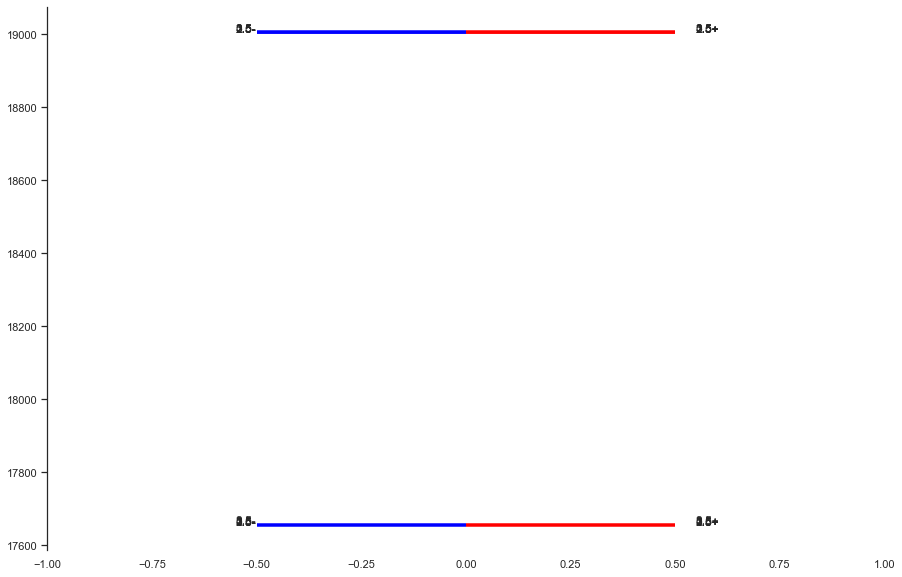

In [151]:
sub_B = False

params_A010 = params
plt.figure(figsize=(15,10))
for J in np.arange(1/2,4):
    Hp = A010(J,1,params_A010)
    Hm = A010(J,-1,params_A010)
    vals_p,vecs_p = np.linalg.eigh(Hp)
    vals_m,vecs_m = np.linalg.eigh(Hm)
    print((vals_p-vals_m)*29979.2458)
    _J = [J for val in vals_p]
    [plt.hlines(y=val,color='red',xmin=0.0,xmax=0.5) for val in vals_p]
    [plt.annotate(f'{J}+',(0.55,val)) for val in vals_p]
    [plt.hlines(y=val,color='blue',xmin=-0.5,xmax=-0.0) for val in vals_m]
    [plt.annotate(f'{J}-',(-0.55,val)) for val in vals_m]

# plt.ylim(33,40)
plt.xlim(-1,1)

In [152]:
def sig0_resid(params,data_p,data_m,Jmax=1/2,uncertainty=0.001, no_uncert=False):
    theory_p = []
    theory_m = []
    for J in np.arange(1/2,Jmax+1):
        HJp = A010(J,1,params)
        HJm = A010(J,-1,params)
        vals_p,vecs_p = np.linalg.eigh(HJp)
        vals_m,vecs_m = np.linalg.eigh(HJm)
        if J==1/2:
            theory_p=vals_p.min()
            theory_m=vals_m.min()
        else:
            theory_p.append(sorted(vals_p)[0])
            theory_p.append(sorted(vals_p)[1])
            theory_m.append(sorted(vals_m)[0])
            theory_m.append(sorted(vals_m)[1])
    all_data  = np.array([data_p,data_m])
#     all_data-=all_data.min()
    all_theory = np.array([theory_p,theory_m])
#     all_theory-=all_theory.min()
    if no_uncert:
        uncertainty=1
    resid = (all_data - all_theory)/uncertainty
    return resid

def A010_resid(params,data_p,data_m,Jmax=5/2,uncertainty = 0.001,no_uncert = False):
    theory_p = []
    theory_m = []
    for J in np.arange(1/2,Jmax+1):
        HJp = A010(J,1,params)
        HJm = A010(J,-1,params)
        vals_p,vecs_p = np.linalg.eigh(HJp)
        vals_m,vecs_m = np.linalg.eigh(HJm)
        if J==1/2:
            theory_p.append(vals_p.min())
            theory_m.append(vals_m.min())
        else:
            theory_p.append(sorted(vals_p)[0])
            theory_p.append(sorted(vals_p)[1])
            theory_m.append(sorted(vals_m)[0])
            theory_m.append(sorted(vals_m)[1])
    all_data  = np.concatenate((data_p,data_m))
#     all_data-= all_data[0]
    all_theory = np.concatenate((theory_p,theory_m))
#     all_theory-=all_theory[0]
    if no_uncert:
        uncertainty=1
    resid = (all_data - all_theory)/uncertainty
    return resid

In [153]:
data_p = [17651.4518,17651.8628,17652.6353,17652.8624,17654.1210]
data_m = [17651.4685,17651.8466,17652.6182,17652.8845,17654.1462]

In [155]:
params = Parameters()
params.add('w2', value=328.93,min=320,max=340,vary=True)
params.add('A', value=1350,vary=False)
params.add('D',value=0,vary=False)
params.add('eDw2',value=0,vary=False)
params.add('B', value=0.253,min=0.23,max=0.27,vary=True)
params.add('pe',value=-0.4378,min=-5,max=5,vary=False)
# params.add('qe',value=0.001,min=-0.1,max=0.1,vary=True)
params.add('pv',value=-0.4378,min=-5,max=5,vary=False)
# params.add('qv',value=-0.001,min=-0.1,max=0.1,vary=True)
params.add('gK',value=0.2458,min=-5,max=5,vary=True)
params.add('gamma',1.3,min=-5,max=5, vary=True)
# params.add('e',-0.1,min=-0.5,max=-0.01, vary=True)
params.add('e',-0.05,min=-0.5,max=-0.001, vary=True)
# params.add('ew2',-30,min=-50,max=-1, vary=True)
params.add('T0',17998.5875,min=0,max=18010, vary=False)

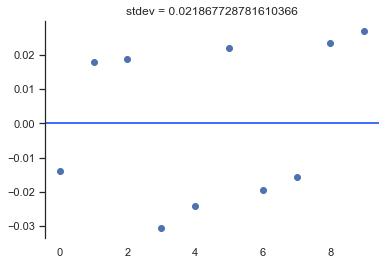

In [156]:
initial_resid = A010_resid(params,data_p,data_m,no_uncert=True)
plt.figure()
plt.plot(initial_resid, 'bo')
plt.axhline(y=0)
plt.title('stdev = '+ str(initial_resid.std()))
plt.show()

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
A          1350     -inf      inf     None    False     None     None
B        0.2525     0.23     0.27     None     True     None     None
D             0     -inf      inf     None    False     None     None
T0      1.8e+04        0 1.801e+04     None    False     None     None
e      -0.001001     -0.5   -0.001     None     True     None     None
eDw2          0     -inf      inf     None    False     None     None
gK       0.2789       -5        5     None     True     None     None
gamma     1.703       -5        5     None     True     None     None
pe      -0.4378       -5        5     None    False     None     None
pv      -0.4378       -5        5     None    False     None     None
w2        329.1      320      340     None     True     None     None


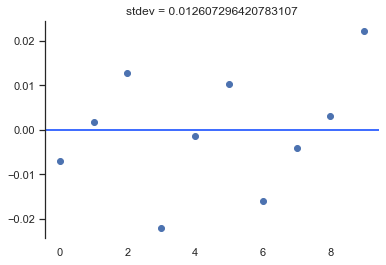

In [157]:
out = minimize(A010_resid, params, args=([data_p,data_m]),method='nelder')#,kws={'flist':True})#,method='least_squares')
out.params.pretty_print()
final_resid = A010_resid(out.params,data_p,data_m,no_uncert=True)
plt.figure()
plt.plot(final_resid, 'bo')
plt.axhline(y=0)
plt.title('stdev = '+ str(final_resid.std()))
plt.show()

In [141]:
# Hm[0,1]**2/(1350) - Hp[0,1]**2/(1350)

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
A          1350     -inf      inf        0    False     None     None
B        0.2526     0.23     0.27 0.0001823     True     None     None
D             0     -inf      inf        0    False     None     None
T0      1.8e+04        0 1.801e+04        0    False     None     None
e      -0.06788     -0.5   -0.001 0.003767     True     None     None
eDw2          0     -inf      inf        0    False     None     None
gK       0.2156       -5        5 0.006904     True     None     None
gamma   0.01801       -5        5  0.03419     True     None     None
pe      -0.4378       -5        5        0    False     None     None
pv      -0.4378       -5        5        0    False     None     None
w2        327.9      320      340  0.08454     True     None     None


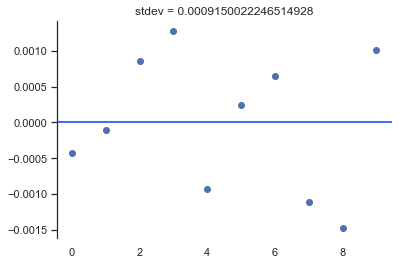

In [158]:
mini = lmfit.Minimizer(A010_resid, out.params, fcn_args=([data_p,data_m]))
out2 = mini.minimize(method='least_squares')#,kws={'flist':True})#,method='least_squares')
out2.params.pretty_print()
final_resid2 = A010_resid(out2.params,data_p,data_m,no_uncert=True)
plt.figure()
plt.plot(final_resid2, 'bo')
plt.axhline(y=0)
plt.title('stdev = '+ str(final_resid2.std()))
plt.show()
out2

In [159]:
ci, trace = lmfit.conf_interval(mini, out2, sigmas=[1, 2,3], trace=True)
lmfit.printfuncs.report_ci(ci)

          99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 w2   :  -0.48943  -0.22375  -0.09783 327.87514  +0.09747  +0.22041  +0.47119
 B    :  -0.00098  -0.00048  -0.00020   0.25264  +0.00020  +0.00048  +0.00099
 gK   :  -0.04197  -0.01946  -0.00785   0.21561  +0.00732  +0.01697  +0.03259
 gamma:  -0.25150  -0.10207  -0.03959   0.01801  +0.03598  +0.08078  +0.15236
 e    :  -0.02072  -0.00995  -0.00417  -0.06788  +0.00414  +0.00992  +0.02057


In [160]:
c_info = [
    lmfit.conf_interval2d(mini, out2, 'gK', 'e', 30, 30),
    lmfit.conf_interval2d(mini, out2, 'gamma', 'e', 30, 30),
    lmfit.conf_interval2d(mini, out2, 'w2', 'e', 30, 30),
    lmfit.conf_interval2d(mini, out2, 'gK', 'gamma', 30, 30),
    lmfit.conf_interval2d(mini, out2, 'w2', 'gK', 30, 30),
    lmfit.conf_interval2d(mini, out2, 'w2', 'gamma', 30, 30)
]

In [161]:
xy_labels = [
    ['$g_K$','$\\epsilon$'],
    ['$\\gamma$','$\\epsilon$'],
    ['$\\omega_2$','$\\epsilon$'],
    ['$g_K$','$\\gamma$'],
    ['$\\omega_2$','$g_K$'],
    ['$\\omega_2$','$\\gamma$']
]

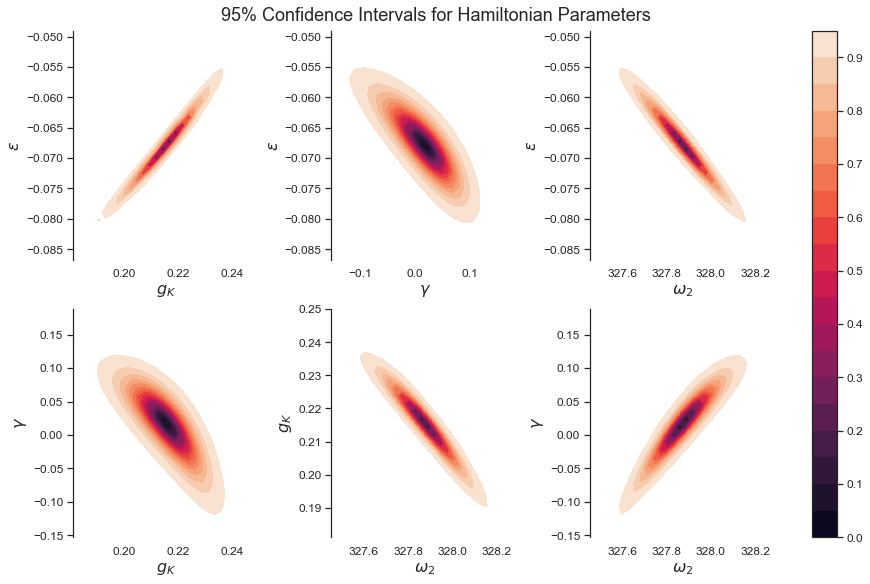

In [162]:
# plot confidence intervals
fig, axes = plt.subplots(2, 3, figsize=(12, 8),constrained_layout=True)
plt.suptitle('95% Confidence Intervals for Hamiltonian Parameters',fontsize=18)
axes = axes.flatten()

for i,ax in enumerate(axes):
    cx,cy,grid = c_info[i]
    ctp = ax.contourf(cx, cy, grid,np.linspace(0, 0.95, 20))
    ax.set_xlabel(xy_labels[i][0],fontsize=16)
    ax.set_ylabel(xy_labels[i][1],fontsize=16)
    ax.tick_params(axis='both',labelsize=12)
cbar = fig.colorbar(ctp,ax=axes.tolist())
cbar.ax.tick_params(labelsize=12) 
plt.savefig('A010_95p_eps_gk_g_w2.pdf',format='pdf')
plt.savefig('A010_95p_eps_gk_g_w2.svg',format='svg')

In [188]:
params = Parameters()
params.add('w2', value=out2.params['w2'].value,min=320,max=340,vary=False) #328.85
params.add('A', value=1350,vary=False)
params.add('D',value=0,vary=False)
params.add('eDw2',value=0,vary=False)
params.add('B', value=0.253,min=0.23,max=0.27,vary=True)
params.add('pe',value=-0.4378,min=-5,max=5,vary=False)
# params.add('qe',value=0.001,min=-0.1,max=0.1,vary=True)
params.add('pv',value=-0.4378,min=-5,max=5,vary=False)
# params.add('qv',value=-0.001,min=-0.1,max=0.1,vary=True)
params.add('gK',value=out2.params['gK'].value,min=-5,max=5,vary=True)
params.add('gamma',out2.params['gamma'].value,min=-5,max=5, vary=False)
# params.add('e',-0.05,min=-0.5,max=-0.001, vary=True)
params.add('ew2',out2.params['w2'].value*out2.params['e'].value,min=-50,max=-1, vary=True)
params.add('T0',17998.5875,min=0,max=18010, vary=False)

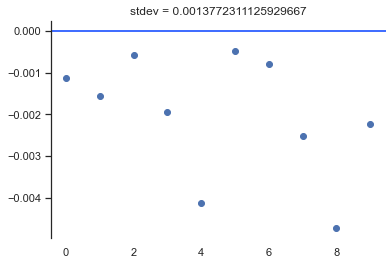

In [189]:
initial_resid = A010_resid(params,data_p,data_m,no_uncert=True)
plt.figure()
plt.plot(initial_resid, 'bo')
plt.axhline(y=0)
plt.title('stdev = '+ str(initial_resid.std()))
plt.show()

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
A          1350     -inf      inf     None    False     None     None
B        0.2526     0.23     0.27     None     True     None     None
D             0     -inf      inf     None    False     None     None
T0      1.8e+04        0 1.801e+04     None    False     None     None
eDw2          0     -inf      inf     None    False     None     None
ew2      -22.25      -50       -1     None     True     None     None
gK       0.2156       -5        5     None     True     None     None
gamma   0.01801       -5        5     None    False     None     None
pe      -0.4378       -5        5     None    False     None     None
pv      -0.4378       -5        5     None    False     None     None
w2        327.9      320      340     None    False     None     None


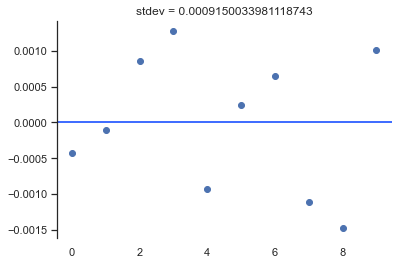

In [190]:
out3 = minimize(A010_resid, params, args=([data_p,data_m]),method='nelder')#,kws={'flist':True})#,method='least_squares')
out3.params.pretty_print()
final_resid3 = A010_resid(out3.params,data_p,data_m,no_uncert=True)
plt.figure()
plt.plot(final_resid3, 'bo')
plt.axhline(y=0)
plt.title('stdev = '+ str(final_resid3.std()))
plt.show()

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
A          1350     -inf      inf        0    False     None     None
B        0.2526     0.23     0.27 0.0001538     True     None     None
D             0     -inf      inf        0    False     None     None
T0      1.8e+04        0 1.801e+04        0    False     None     None
eDw2          0     -inf      inf        0    False     None     None
ew2      -22.25      -50       -1   0.0189     True     None     None
gK       0.2156       -5        5 0.001057     True     None     None
gamma   0.01801       -5        5        0    False     None     None
pe      -0.4378       -5        5        0    False     None     None
pv      -0.4378       -5        5        0    False     None     None
w2        327.9      320      340        0    False     None     None


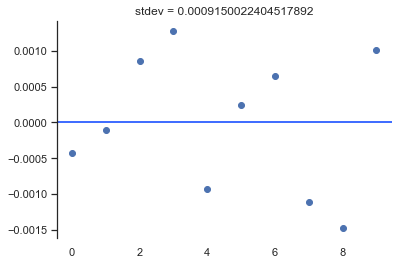

In [191]:
mini = lmfit.Minimizer(A010_resid, out3.params, fcn_args=([data_p,data_m]))
out4 = mini.minimize(method='least_squares')#,kws={'flist':True})#,method='least_squares')
out4.params.pretty_print()
final_resid4 = A010_resid(out4.params,data_p,data_m,no_uncert=True)
plt.figure()
plt.plot(final_resid4, 'bo')
plt.axhline(y=0)
plt.title('stdev = '+ str(final_resid4.std()))
plt.show()
out4

In [192]:
c_info2 = [
    lmfit.conf_interval2d(mini, out4, 'gK', 'ew2', 30, 30),
    lmfit.conf_interval2d(mini, out4, 'gamma', 'ew2', 30, 30),
    lmfit.conf_interval2d(mini, out2, 'gK', 'gamma', 30, 30),
]

In [193]:
xy_labels2 = [
    ['$g_K$','$\\epsilon\\omega_2$'],
    ['$\\gamma$','$\\epsilon\\omega_2$'],
    ['$g_K$','$\\gamma$'],
]

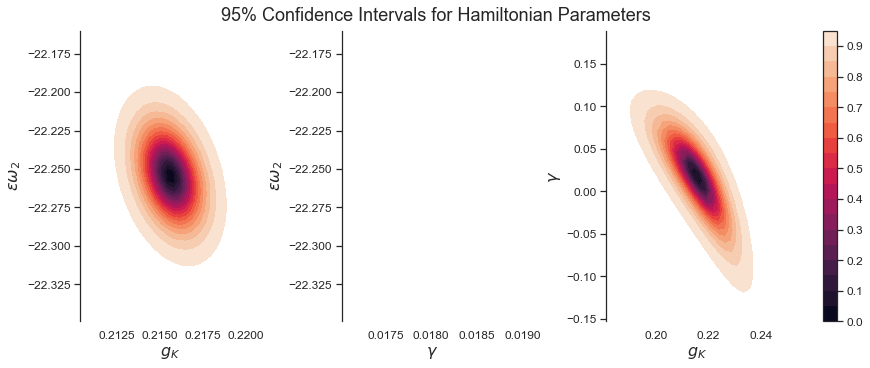

In [194]:
# plot confidence intervals
fig, axes = plt.subplots(1, 3, figsize=(12, 5),constrained_layout=True)
plt.suptitle('95% Confidence Intervals for Hamiltonian Parameters',fontsize=18)
axes = axes.flatten()

for i,ax in enumerate(axes):
    cx,cy,grid = c_info2[i]
    ctp = ax.contourf(cx, cy, grid,np.linspace(0, 0.95, 20))
    ax.set_xlabel(xy_labels2[i][0],fontsize=16)
    ax.set_ylabel(xy_labels2[i][1],fontsize=16)
    ax.tick_params(axis='both',labelsize=12)
cbar = fig.colorbar(ctp,ax=axes.tolist())
cbar.ax.tick_params(labelsize=12) 
plt.savefig('A010_95p_ew2_gk_g.pdf',format='pdf')
plt.savefig('A010_95p_ew2_gk_g.svg',format='svg')

In [64]:
sns.set_style({"axes.spines.bottom":False,'axes.spines.top':False,'axes.spines.right':False,'ytick.left':True,'ytick.direction':'out'})

In [34]:
sns.axes_style()

{'axes.facecolor': 'white',
 'axes.edgecolor': '.15',
 'axes.grid': False,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'grid.color': '.8',
 'grid.linestyle': '-',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': <CapStyle.round: 'round'>,
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'xtick.bottom': False,
 'xtick.top': False,
 'ytick.left': False,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': False,
 'axes.spines.right': False,
 'axes.spines.top': False}

In [52]:
help(plt.ticklabel_format)

Help on function ticklabel_format in module matplotlib.pyplot:

ticklabel_format(*, axis='both', style='', scilimits=None, useOffset=None, useLocale=None, useMathText=None)
    Configure the `.ScalarFormatter` used by default for linear axes.
    
    If a parameter is not set, the corresponding property of the formatter
    is left unchanged.
    
    Parameters
    ----------
    axis : {'x', 'y', 'both'}, default: 'both'
        The axis to configure.  Only major ticks are affected.
    
    style : {'sci', 'scientific', 'plain'}
        Whether to use scientific notation.
        The formatter default is to use scientific notation.
    
    scilimits : pair of ints (m, n)
        Scientific notation is used only for numbers outside the range
        10\ :sup:`m` to 10\ :sup:`n` (and only if the formatter is
        configured to use scientific notation at all).  Use (0, 0) to
        include all numbers.  Use (m, m) where m != 0 to fix the order of
        magnitude to 10\ :sup:`m`

Text(0.5, 1.0, '$\\tilde{A}(010)$ Levels')

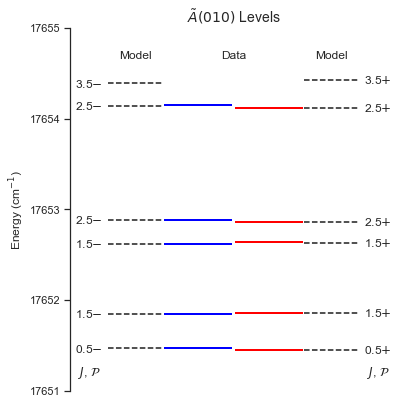

In [104]:
from matplotlib.ticker import StrMethodFormatter
sub_B = False
fitparams = out4.params
fig = plt.figure(figsize=(5.5,5.5),constrained_layout=True)
depert = False
off=[]
for J in np.arange(1/2,16):
    Hp = A010(J,1,fitparams,depert=depert)
    Hm = A010(J,-1,fitparams,depert=depert)
    vals_p,vecs_p = np.linalg.eigh(Hp)
    vals_m,vecs_m = np.linalg.eigh(Hm)
    if J==1/2:
        off = [min(data_p)-min(vals_p),min(data_m)-min(vals_m)]
        off = [0,0]
#     print((vals_p-vals_m)*29979.2458)
    [plt.hlines(y=val+off[0],color='red',xmin=0.005,xmax=0.255) for val in data_p]
    [plt.hlines(y=val+off[1],color='blue',xmin=-0.255,xmax=-0.005) for val in data_m]
    [plt.hlines(y=_p,color='k',linestyle='--',xmin=0.26,xmax=0.46) for _p in vals_p]
    [plt.hlines(y=_m,color='k',linestyle='--',xmin=-0.46,xmax=-0.26) for _m in vals_m]
    [plt.annotate(f'{J}$+$',(0.53,val+off[0]),verticalalignment='center',horizontalalignment='center') for val in vals_p]
    [plt.annotate(f'{J}$-$',(-0.53,val+off[1]),verticalalignment='center',horizontalalignment='center') for val in vals_m]
# sns.despine()
plt.xticks([])
plt.annotate(r'$J$, $\mathcal{P}$',(-0.53,17651.2),verticalalignment='center',horizontalalignment='center')
plt.annotate(r'$J$, $\mathcal{P}$',(0.53,17651.2),verticalalignment='center',horizontalalignment='center')
plt.yticks([17651,17652,17653,17654,17655])
plt.annotate('Data',(0,17654.7),verticalalignment='center',horizontalalignment='center')
plt.annotate('Model',(-0.36,17654.7),verticalalignment='center',horizontalalignment='center')
plt.annotate('Model',(0.36,17654.7),verticalalignment='center',horizontalalignment='center')
plt.ylim(17651,17655)
plt.xlim(-0.6,0.6)
plt.ylabel('Energy (cm$^{-1}$)')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.title(r'$\tilde{A}(010)$ Levels',fontsize=14)

In [105]:
fig.savefig(save+'A010_levels_fit.pdf')
fig.savefig(save+'A010_levels_fit.svg')

(-1.0, 1.0)

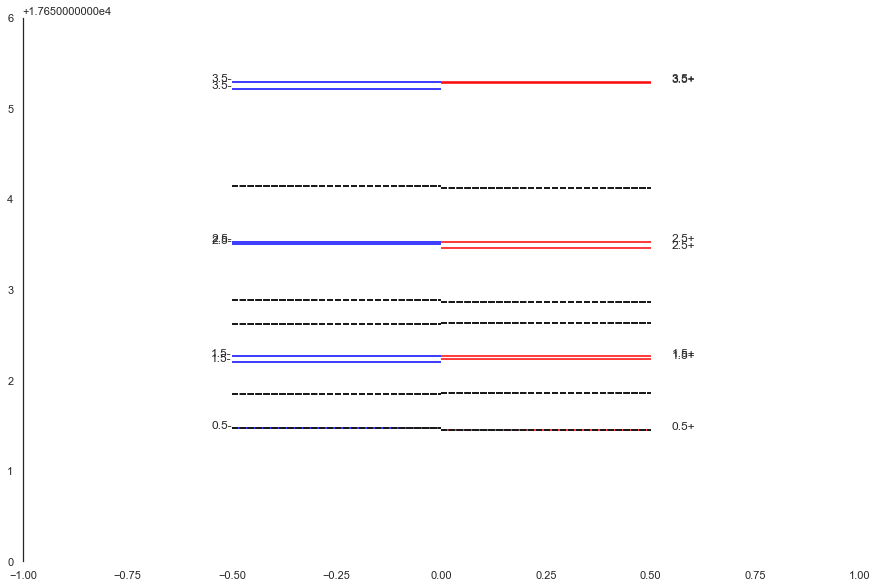

In [45]:
sub_B = False
fitparams = out2.params
plt.figure(figsize=(15,10))
depert = True
off=[]
for J in np.arange(1/2,16):
    Hp = A010(J,1,fitparams,depert=depert)
    Hm = A010(J,-1,fitparams,depert=depert)
    vals_p,vecs_p = np.linalg.eigh(Hp)
    vals_m,vecs_m = np.linalg.eigh(Hm)
    if J==1/2:
        off = [min(data_p)-min(vals_p),min(data_m)-min(vals_m)]
#     print((vals_p-vals_m)*29979.2458)
    [plt.hlines(y=val+off[0],color='red',xmin=0.0,xmax=0.5) for val in vals_p]
    [plt.annotate(f'{J}+',(0.55,val+off[0])) for val in vals_p]
    [plt.hlines(y=val+off[1],color='blue',xmin=-0.5,xmax=-0.0) for val in vals_m]
    [plt.hlines(y=_p,color='k',linestyle='--',xmin=0.0,xmax=0.5) for _p in data_p]
    [plt.hlines(y=_m,color='k',linestyle='--',xmin=-0.5,xmax=0.0) for _m in data_m]
    [plt.annotate(f'{J}-',(-0.55,val+off[1])) for val in vals_m]

plt.ylim(17650,17656)
plt.xlim(-1,1)

In [25]:
data_p

[17651.4518, 17651.8628, 17652.6353, 17652.8624, 17654.121]

(-0.6, 0.6)

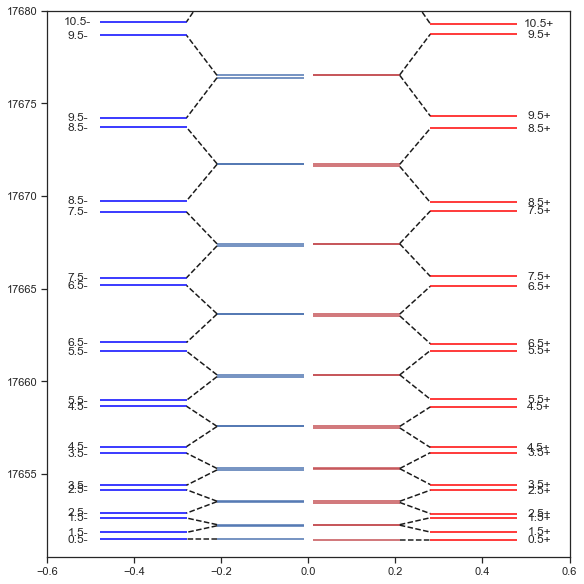

In [26]:
sub_B = False
fitparams = out2.params
plt.figure(figsize=(8,8),constrained_layout=True)
depert = True
plevels = []
mlevels = []
for J in np.arange(1/2,15):
    Hp = A010(J,1,fitparams,depert=depert)
    Hm = A010(J,-1,fitparams,depert=depert)
    valsd_p,vecs_p = np.linalg.eigh(Hp)
    valsd_m,vecs_m = np.linalg.eigh(Hm)
    valsd_p-=sub_B*fitparams['B']*J*(J+1)
    valsd_m-=sub_B*fitparams['B']*J*(J+1)
#     if J==1/2:
#         off = [min(data_p)-min(valsd_p),min(data_m)-min(valsd_m)]
#     print((vals_p-vals_m)*29979.2458)
    ept = 0.2
    off = 0.01
    sep = 0.07
    [plt.hlines(y=val,color='r',linestyle='-',xmin=off,xmax=ept+off) for val in valsd_p]
    [plt.hlines(y=val,color='b',linestyle='-',xmin=-ept-off,xmax=-off) for val in valsd_m]

    Hp = A010(J,1,fitparams,depert=False)
    Hm = A010(J,-1,fitparams,depert=False)
    vals_p,vecs_p = np.linalg.eigh(Hp)
    vals_m,vecs_m = np.linalg.eigh(Hm)
    vals_p-=sub_B*fitparams['B']*J*(J+1)
    vals_m-=sub_B*fitparams['B']*J*(J+1)
    [plt.hlines(y=_p,color='red',xmin=ept+off+sep,xmax=2*ept+off+sep) for _p in vals_p]
    [plt.hlines(y=_m,color='blue',xmin=-off-2*ept-sep,xmax=-off-ept-sep) for _m in vals_m]
    [plt.annotate(f'{J}+',(2*ept+off+sep+0.05,val),verticalalignment='center',horizontalalignment='center') for val in vals_p]
    [plt.annotate(f'{J}-',(-(2*ept+off+sep+0.05),val),verticalalignment='center',horizontalalignment='center') for val in vals_m]

    m_slope = [(vm - dm)/(-sep) for (vm,dm) in zip(vals_m, valsd_m)]
    p_slope = [(vp - dp)/(sep) for (vp,dp) in zip(vals_p, valsd_p)]
    
    xp = np.linspace(ept+off,ept+off+sep)
    xm = np.linspace(-(ept+off),-(ept+off+sep))
    [plt.plot(xp,ps*(xp-(ept+off))+dp,'k',linestyle='--') for (ps,dp) in zip(p_slope, valsd_p)]
    [plt.plot(xm,ms*(xm+((ept+off)))+dm,'k',linestyle='--') for (ms,dm) in zip(m_slope, valsd_m)]
    
    [plevels.append(plev) for plev in vals_p[vals_p<19000]]
    [mlevels.append(mlev) for mlev in vals_m[vals_m<19000]]
    

plt.ylim(17650.5,17680)
plt.xlim(-0.6,0.6)

Text(0.5, 1.02, '$\\tilde{A}(010)$ Deperturbation')

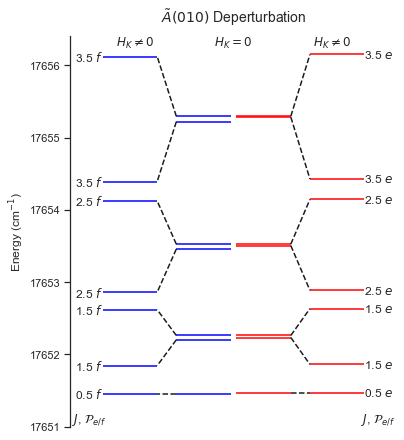

In [129]:
sub_B = False
fitparams = out2.params
fig=plt.figure(figsize=(5.5,6),constrained_layout=True)
elevels = []
flevels = []
for J in np.arange(1/2,15):
    nolL = copy.deepcopy(fitparams)
    nolL['pe'].value = 0
    nolL['pv'].value = 0
    Hp = A010(J,1,nolL)
    Hm = A010(J,-1,nolL)
    valsd_p,vecs_p = np.linalg.eigh(Hp)
    valsd_m,vecs_m = np.linalg.eigh(Hm)
    if (-1)**(J-1/2-1)<0:
        e_par = valsd_m
        f_par = valsd_p
    else:
        e_par = valsd_p
        f_par = valsd_m
    valsd_p = e_par
    valsd_m = f_par
    valsd_p-=sub_B*nolL['B']*J*(J+1)
    valsd_m-=sub_B*nolL['B']*J*(J+1)
#     if J==1/2:
#         off = [min(data_p)-min(valsd_p),min(data_m)-min(valsd_m)]
#     print((vals_p-vals_m)*29979.2458)
    ept = 0.2
    off = 0.01
    sep = 0.07
    [plt.hlines(y=val,color='red',linestyle='-',xmin=off,xmax=ept+off) for val in valsd_p]
    [plt.hlines(y=val,color='blue',linestyle='-',xmin=-ept-off,xmax=-off) for val in valsd_m]
    
    all_int = copy.deepcopy(fitparams)
    Hp = A010(J,1,all_int)
    Hm = A010(J,-1,all_int)
    vals_p,vecs_p = np.linalg.eigh(Hp)
    vals_m,vecs_m = np.linalg.eigh(Hm)
    if (-1)**(J-1/2-1)<0:
        e_par = vals_m
        f_par = vals_p
    else:
        e_par = vals_p
        f_par = vals_m
    vals_p = e_par
    vals_m = f_par
    vals_p-=sub_B*all_int['B']*J*(J+1)
    vals_m-=sub_B*all_int['B']*J*(J+1)
    [plt.hlines(y=_p,color='red',xmin=ept+off+sep,xmax=2*ept+off+sep) for _p in vals_p]
    [plt.hlines(y=_m,color='blue',xmin=-off-2*ept-sep,xmax=-off-ept-sep) for _m in vals_m]

    m_slope = [(vm - dm)/(-sep) for (vm,dm) in zip(vals_m, valsd_m)]
    p_slope = [(vp - dp)/(sep) for (vp,dp) in zip(vals_p, valsd_p)]
    
    xp = np.linspace(ept+off,ept+off+sep)
    xm = np.linspace(-(ept+off),-(ept+off+sep))
    [plt.plot(xp,ps*(xp-(ept+off))+dp,'k',linestyle='--') for (ps,dp) in zip(p_slope, valsd_p)]
    [plt.plot(xm,ms*(xm+((ept+off)))+dm,'k',linestyle='--') for (ms,dm) in zip(m_slope, valsd_m)]

    [plt.annotate(f'{J} $e$',(2*ept+off+sep+0.05,val),verticalalignment='center',horizontalalignment='center') for val in vals_p]
    [plt.annotate(f'{J} $f$',(-(2*ept+off+sep+0.05),val),verticalalignment='center',horizontalalignment='center') for val in vals_m]
    
    [elevels.append(elev) for elev in vals_p[vals_p<19000]]
    [flevels.append(flev) for flev in vals_m[vals_m<19000]]

plt.xticks([])
plt.ylim(17651,17656.4)
plt.xlim(-0.6,0.6)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.annotate('$H_K=0$',(0,17656.3),verticalalignment='center',horizontalalignment='center')
plt.annotate('$H_K\\neq 0$',(-0.36,17656.3),verticalalignment='center',horizontalalignment='center')
plt.annotate('$H_K\\neq 0$',(0.36,17656.3),verticalalignment='center',horizontalalignment='center')
plt.annotate(r'$J$, $\mathcal{P}_{e/f}$',(-0.53,17651.1),verticalalignment='center',horizontalalignment='center')
plt.annotate(r'$J$, $\mathcal{P}_{e/f}$',(0.53,17651.1),verticalalignment='center',horizontalalignment='center')
plt.ylabel('Energy (cm$^{-1}$)')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.title(r'$\tilde{A}(010)$ Deperturbation',y=1.02,fontsize=14)

In [130]:
fig.savefig(save+'A010_depert_levels.pdf')
fig.savefig(save+'A010_depert_levels.svg')

In [654]:
flevels

[17651.468277647036,
 17651.863127683468,
 17652.634102846114,
 17652.886647506362,
 17654.144466846414,
 17654.426915219636,
 17656.148438481945,
 17656.476610360573,
 17658.653338290787,
 17659.03360411071,
 17661.661295166792,
 17662.097032992166,
 17665.173172663373,
 17665.666477422343,
 17669.189390438874,
 17669.74170820593,
 17673.710177764442,
 17674.322589310268,
 17678.735670748698,
 17679.40903480411,
 17684.265955399034,
 17685.000987695737,
 17690.301088783468,
 17691.09840867566,
 17696.84111028783,
 17697.70126974095,
 17703.88604799162,
 17704.809550395337,
 17711.435922467826]

In [656]:
plevels

[17651.452286953372,
 17651.863127683468,
 17652.634102846114,
 17652.860435570958,
 17654.122706102524,
 17654.426915219636,
 17656.148438481945,
 17656.43185905142,
 17658.61813314016,
 17659.03360411071,
 17661.661295166792,
 17662.0324291518,
 17665.12583327195,
 17665.666477422343,
 17669.189390438874,
 17669.655956108272,
 17673.651995670305,
 17674.322589310268,
 17678.735670748698,
 17679.30084123349,
 17684.1982184333,
 17685.000987695737,
 17690.301088783468,
 17690.966480728173,
 17696.765104773385,
 17697.70126974095,
 17703.88604799162,
 17704.652594925476,
 17711.352933772712]

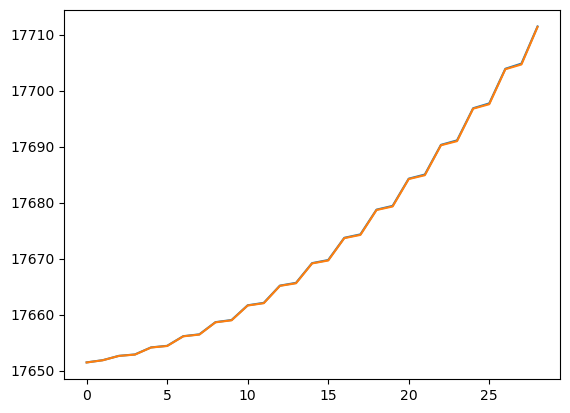

In [657]:
plt.plot(flevels)
plt.plot(elevels)

In [658]:
sr_e = []
sr_f = []
B_e = []
B_f = []
mean = []
for i in range(0,len(flevels),2):
    if i==len(flevels)-1:
        continue
    delta_e = abs(elevels[i+1]-elevels[i])
    delta_f = abs(flevels[i+1]-flevels[i])
    mean_e = (elevels[i+1]+elevels[i])/2
    mean_f = (flevels[i+1]+flevels[i])/2
    sr_e.append(delta_e)
    sr_f.append(delta_f)
    B_e.append(mean_e)
    B_f.append(mean_f)

In [659]:
from lmfit.models import QuadraticModel,LinearModel

In [660]:
qmodel = QuadraticModel(independent_vars=['x'])
pars = Parameters()
pars.add('a', value=0.25, min=0, max=1)
pars.add('b', expr='a')
pars.add('c',17651,min=17650,max=17654)

In [661]:
N = np.arange(1,len(B_f)+1,1)

In [662]:
resf = qmodel.fit(B_f,pars,x=N)
rese = qmodel.fit(B_e,pars,x=N)

In [663]:
resf

In [664]:
rese

In [665]:
pars = Parameters()
pars.add('frac_curve1', value=0.5, min=0, max=1)
pars.add('frac_curve2', expr='1-frac_curve1')

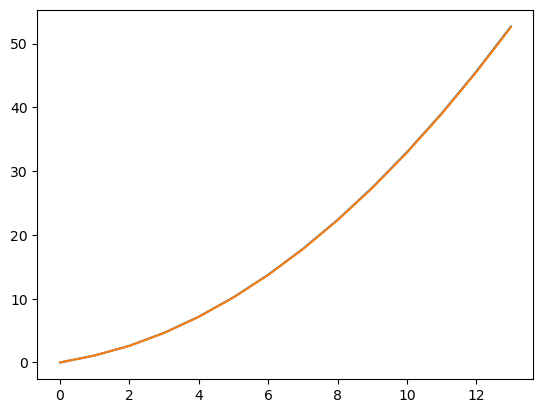

In [666]:
plt.plot(B_f-B_f[0])
plt.plot(B_e-B_e[0])

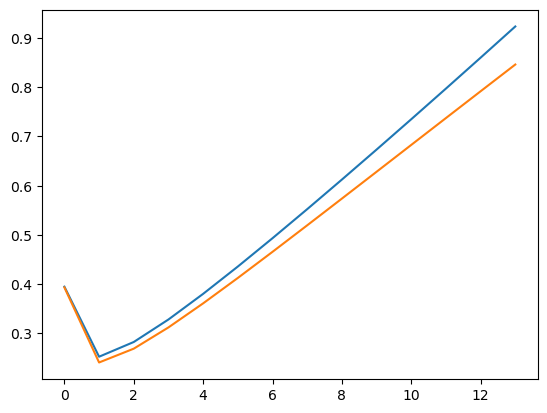

In [669]:
sr_e = np.array(sr_e)
sr_f = np.array(sr_f)
sr_mean = sr_e/2+sr_f/2
plt.plot(sr_f)
plt.plot(sr_e)

In [732]:
from lmfit import Model

def sr_splitting(N,g,l):
    return g/2*(1 - l**2/(N*(N+1)))*N + g/2*(1- l**2/(N*(N+1)))*(N+1)

srmodel = Model(sr_splitting)    

In [750]:
parsf = Parameters()
parsf.add('g', value=0.05, min=0, max=10)
parsf.add('l',value=0,vary=False)
parse = Parameters()
parse.add('g', value=0.05, min=0, max=10)
parse.add('l',value=0,vary=False)


In [755]:
Ni=8
resf = srmodel.fit(sr_f[Ni:],parsf,N=N[Ni:])
rese = srmodel.fit(sr_e[Ni:],parse,N=N[Ni:])

In [756]:
resf

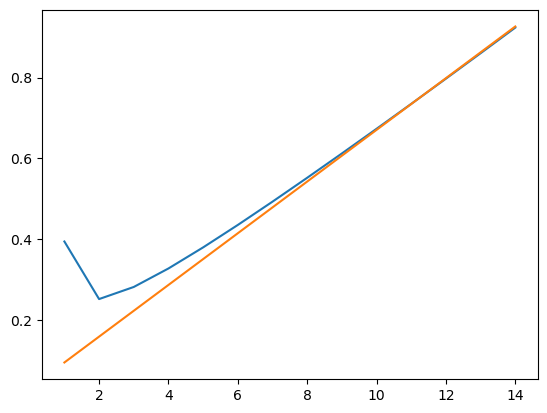

In [757]:
plt.plot(N,sr_f)
# plt.plot(N,sr_e)
plt.plot(N,sr_splitting(N,**resf.params))

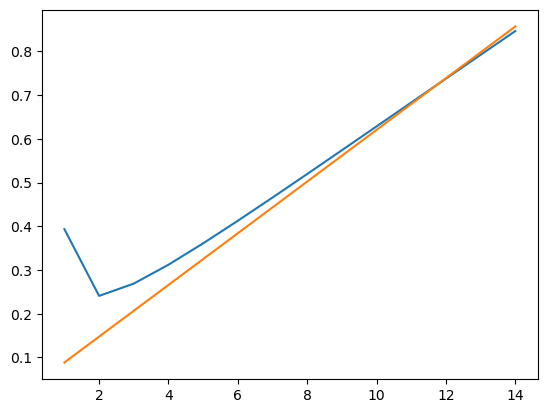

In [758]:
# plt.plot(N,sr_f)
plt.plot(N,sr_e)
plt.plot(N,sr_splitting(N,**rese.params))

In [759]:
rese

In [762]:
print('sr mean',(rese.params['g'].value+resf.params['g'].value)/2)
print('sr diff',(rese.params['g'].value-resf.params['g'].value)/2)

sr mean 0.06148028720939669
sr diff -0.0024000755843323063


In [812]:
print('sr mean',29979.2458*(rese.params['g'].value+resf.params['g'].value)/2)
print('sr diff',29979.2458*(rese.params['g'].value-resf.params['g'].value)/2)

sr mean 1843.1326421050994
sr diff -71.95245588127683


In [476]:
out2.params

name,value,standard error,relative error,initial value,min,max,vary
w2,328.849661,0.05171475,(0.02%),328.84977490868135,320.000000,340.000000,True
A,1350.00000,0.00000000,(0.00%),1350,-inf,inf,False
D,0.00000000,0.00000000,,0,-inf,inf,False
eDw2,0.00000000,0.00000000,,0,-inf,inf,False
B,0.25264939,2.7526e-04,(0.11%),0.2526495606777615,0.23000000,0.27000000,True
pe,0.00000000,0.00000000,,-0.4378,-5.00000000,5.00000000,False
pv,0.00000000,0.00000000,,-0.4378,-5.00000000,5.00000000,False
gK,0.21517335,0.01045953,(4.86%),0.21514907283569507,-5.00000000,5.00000000,True
gamma,0.98996704,0.05099466,(5.15%),0.9898728904051008,-5.00000000,5.00000000,True
e,-0.06787683,0.00569102,(8.38%),-0.06789138144196571,-0.50000000,-1.0000e-03,True


In [767]:
elevels = np.array(elevels)
flevels = np.array(flevels)

In [772]:
dparity = elevels - flevels

In [784]:
qeff = ((dparity[1:]+dparity[:1])/2)[::2]

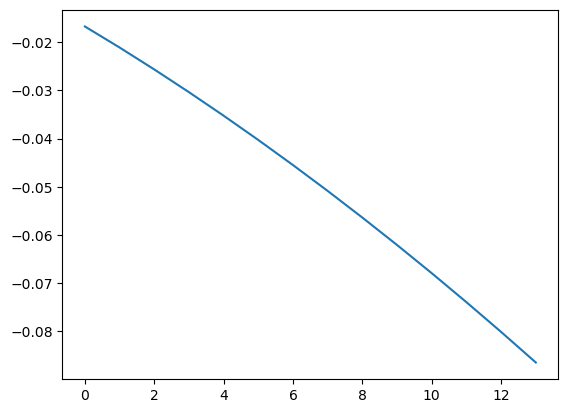

In [785]:
plt.plot(((dparity[1:]+dparity[:1])/2)[::2])

In [808]:
qmodel = QuadraticModel(independent_vars=['x'])
pars = Parameters()
pars.add('a', value=-0.02, min=-1, max=1)
pars.add('b', value=0,vary=True)
pars.add('c',0,vary=True)

In [809]:
res = qmodel.fit(qeff,pars,x=N)
res

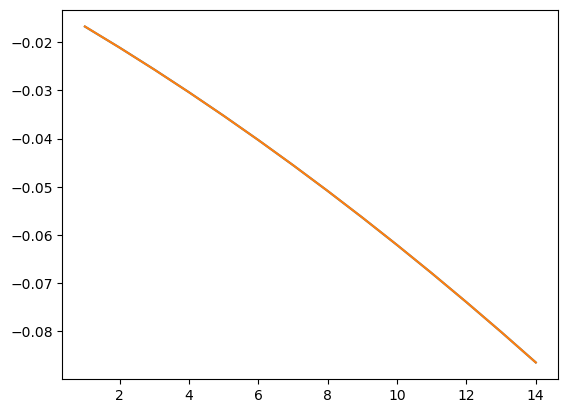

In [811]:
q = res.params['a']
q1 = res.params['b']
q0 = res.params['c']
plt.plot(N,qeff)
plt.plot(N,q*N**2+q1*N+q0)

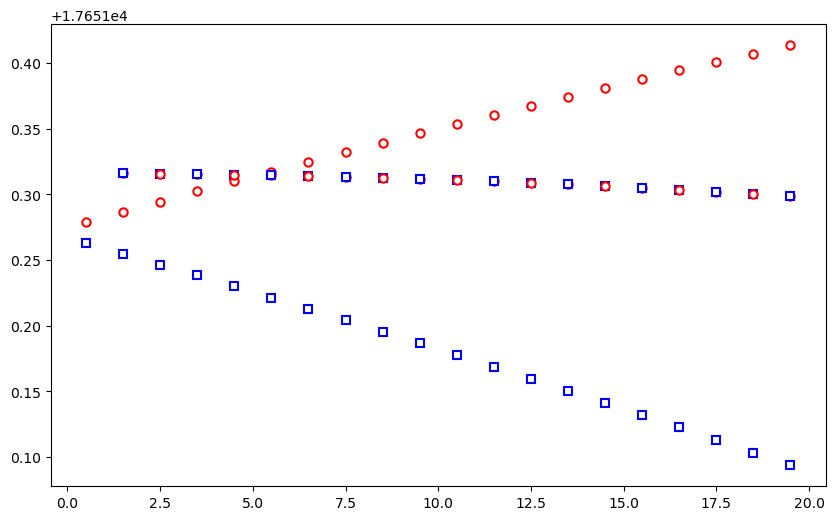

In [410]:
subB = True
fitparams = out2.params
plt.figure(figsize=(10,6))
show_actual=False
off=[]
delta_on_e = []
delta_off_e = []
for J in np.arange(1/2,20.5):
    Hp = A010(J,1,fitparams,depert=True)
    Hm = A010(J,-1,fitparams,depert=True)
    vals_p,vecs_p = np.linalg.eigh(Hp)
    vals_m,vecs_m = np.linalg.eigh(Hm)
    vals_p = vals_p[vals_p<18000]
    vals_m = vals_m[vals_m<18000]
    if J==1/2:
        off = [min(data_p)-min(vals_p),min(data_m)-min(vals_m)]
#     print((vals_p-vals_m)*29979.2458)
    _J = np.array([J for i in vals_p])
    if (-1)**(J-1/2)<1:
        p_mark = 'ro'
        m_mark = 'bs'
    else:
        p_mark = 'bs'
        m_mark = 'ro'
    plt.plot(_J,vals_p-out2.params['B']*subB*_J*(_J+1),p_mark,mfc='white',mew=1.5)
    plt.plot(_J,vals_m-out2.params['B']*subB*_J*(_J+1),m_mark,mfc='white',mew=1.5)
    delta_off_e.append((vals_m.max()-vals_m.min())/2+(vals_p.max()-vals_p.min())/2)
    if show_actual:
        Hp = A010(J,1,fitparams,depert=False)
        Hm = A010(J,-1,fitparams,depert=False)
        vals_p,vecs_p = np.linalg.eigh(Hp)
        vals_m,vecs_m = np.linalg.eigh(Hm)
        vals_p = vals_p[vals_p<18000]
        vals_m = vals_m[vals_m<18000]
        if J==1/2:
            off = [min(data_p)-min(vals_p),min(data_m)-min(vals_m)]
        #     print((vals_p-vals_m)*29979.2458)
        _J = [J for i in vals_p]
        if (-1)**(J-1/2)<1:
            p_mark = 'ro'
            m_mark = 'bs'
        else:
            p_mark = 'bs'
            m_mark = 'ro'
        plt.plot(_J,vals_p-out2.params['B']*subB*J*(J+1),p_mark)
        plt.plot(_J,vals_m-out2.params['B']*subB*J*(J+1),m_mark)
        delta_on_e.append((vals_m.max()-vals_m.min())/2+(vals_p.max()-vals_p.min())/2)

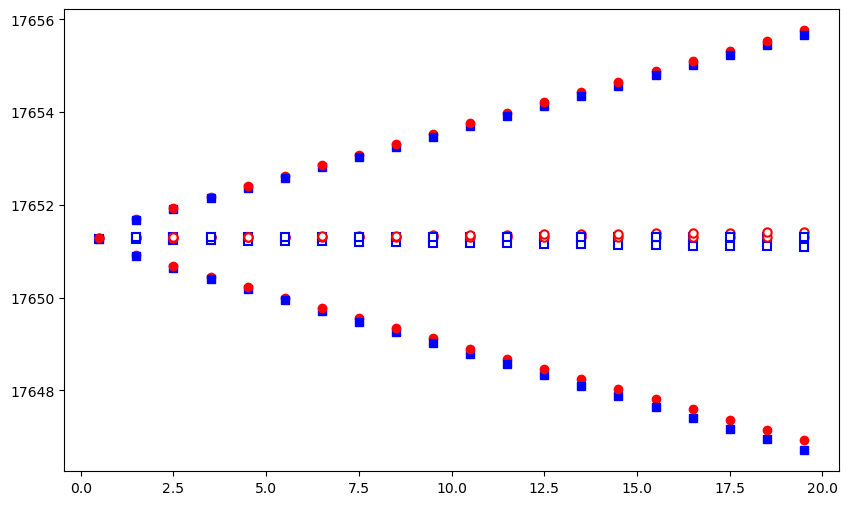

In [395]:
subB = True
fitparams = out2.params
plt.figure(figsize=(10,6))
show_actual=True
off=[]
delta_on_e = []
delta_off_e = []
for J in np.arange(1/2,20.5):
    Hp = A010(J,1,fitparams,depert=True)
    Hm = A010(J,-1,fitparams,depert=True)
    vals_p,vecs_p = np.linalg.eigh(Hp)
    vals_m,vecs_m = np.linalg.eigh(Hm)
    vals_p = vals_p[vals_p<18000]
    vals_m = vals_m[vals_m<18000]
    if J==1/2:
        off = [min(data_p)-min(vals_p),min(data_m)-min(vals_m)]
#     print((vals_p-vals_m)*29979.2458)
    _J = np.array([J for i in vals_p])
    if (-1)**(J-1/2)<1:
        p_mark = 'ro'
        m_mark = 'bs'
    else:
        p_mark = 'bs'
        m_mark = 'ro'
    plt.plot(_J,vals_p-out2.params['B']*subB*_J*(_J+1),p_mark,mfc='white',mew=1.5)
    plt.plot(_J,vals_m-out2.params['B']*subB*_J*(_J+1),m_mark,mfc='white',mew=1.5)
    delta_off_e.append((vals_m.max()-vals_m.min())/2+(vals_p.max()-vals_p.min())/2)
    if show_actual:
        Hp = A010(J,1,fitparams,depert=False)
        Hm = A010(J,-1,fitparams,depert=False)
        vals_p,vecs_p = np.linalg.eigh(Hp)
        vals_m,vecs_m = np.linalg.eigh(Hm)
        vals_p = vals_p[vals_p<18000]
        vals_m = vals_m[vals_m<18000]
        if J==1/2:
            off = [min(data_p)-min(vals_p),min(data_m)-min(vals_m)]
        #     print((vals_p-vals_m)*29979.2458)
        _J = [J for i in vals_p]
        if (-1)**(J-1/2)<1:
            p_mark = 'ro'
            m_mark = 'bs'
        else:
            p_mark = 'bs'
            m_mark = 'ro'
        plt.plot(_J,vals_p-out2.params['B']*subB*J*(J+1),p_mark)
        plt.plot(_J,vals_m-out2.params['B']*subB*J*(J+1),m_mark)
        delta_on_e.append((vals_m.max()-vals_m.min())/2+(vals_p.max()-vals_p.min())/2)

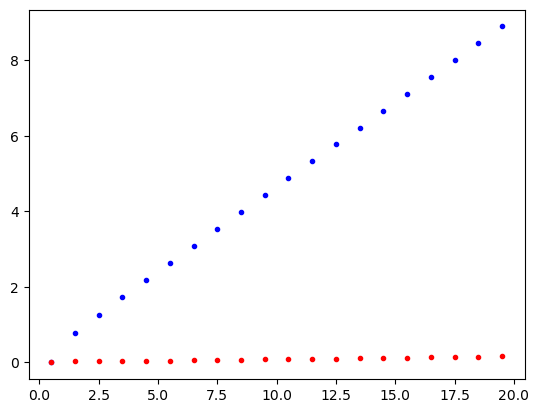

In [398]:
_J = np.arange(1/2,20.5)
plt.plot(_J, delta_on_e,'b.')
plt.plot(_J, delta_off_e,'r.')

In [376]:
(delta_off_e[-1] - delta_off_e[-2])

0.007994635836439556

In [385]:
(22+0.25-1/2)**2/(2*1350) - (22-0.25+1/2)**2/(2*1350) 

-0.008148148148148154

In [386]:
np.sqrt((22-0.25)**2+1350**2)-np.sqrt((22+0.25)**2+1350**2)

-0.008147066275114412

In [344]:
_J

[0.5]

In [302]:
out2.params['B'].value

0.252649390496936

In [298]:
J_data = np.array([1/2,3/2,3/2,5/2,5/2])
data_p-out2.params['B']*J_data*(J_data+1)

array([17651.26231296, 17650.91536479, 17651.68786479, 17650.65171783,
       17651.91031783])

(-1.0, 1.0)

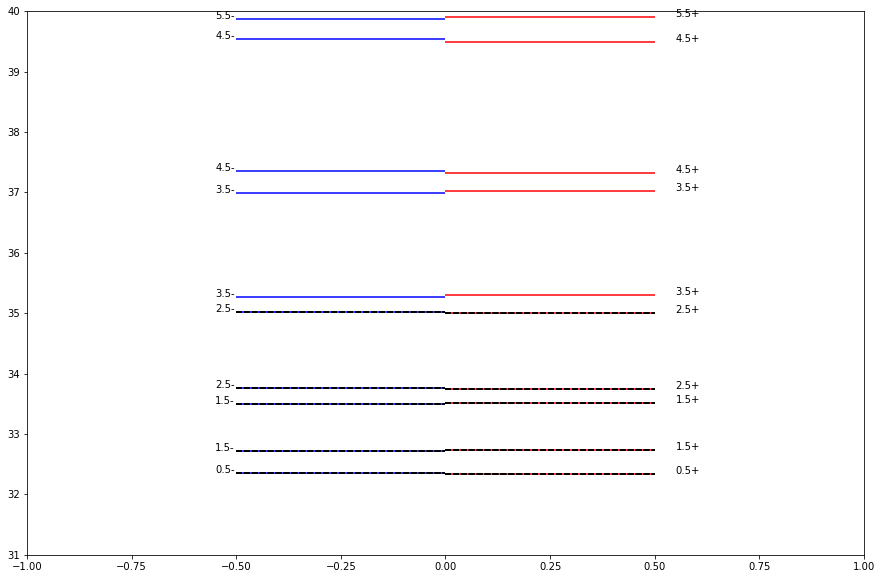

In [40]:
sub_B = False

plt.figure(figsize=(15,10))
off=[]
for J in np.arange(1/2,6):
    Hp = A010(J,1,out2.params)
    Hm = A010(J,-1,out2.params)
    vals_p,vecs_p = np.linalg.eigh(Hp)
    vals_m,vecs_m = np.linalg.eigh(Hm)
    if J==1/2:
        off = [min(vals_p),min(vals_m)]
#     print((vals_p-vals_m)*29979.2458)
    [plt.hlines(y=val,color='red',xmin=0.0,xmax=0.5) for val in vals_p]
    [plt.annotate(f'{J}+',(0.55,val)) for val in vals_p]
    [plt.hlines(y=val,color='blue',xmin=-0.5,xmax=-0.0) for val in vals_m]
    [plt.hlines(y=_p-min(data_p)+off[0],color='k',linestyle='--',xmin=0.0,xmax=0.5) for _p in data_p]
    [plt.hlines(y=_m-min(data_m)+off[1],color='k',linestyle='--',xmin=-0.5,xmax=0.0) for _m in data_m]
    [plt.annotate(f'{J}-',(-0.55,val)) for val in vals_m]

plt.ylim(31,40)
plt.xlim(-1,1)

In [550]:
print(off)

[32.33262353639491, 32.349161803808585]


In [472]:
Hp = A010(3/2,1,out2.params)
Hm = A010(3/2,-1,out2.params)
vals_p,vecs_p = np.linalg.eigh(Hp)
vals_m,vecs_m = np.linalg.eigh(Hm)

In [477]:
Hp

array([[ 3.47432612e+01, -4.79406415e-01, -3.76885586e-01],
       [-4.79406415e-01,  1.28676705e+03, -2.39456630e+01],
       [-3.76885586e-01, -2.39456630e+01,  3.51714279e+01]])

In [473]:
vals_p

array([  34.34200614,   35.11454148, 1287.22519202])

In [487]:
vecs_p.T

array([[-6.93419125e-01, -1.40390276e-02, -7.20397684e-01],
       [-7.20534368e-01,  1.29876635e-02,  6.93297588e-01],
       [ 3.76941257e-04, -9.99817096e-01,  1.91214961e-02]])

In [471]:
vecs_m

array([[-0.0192932 , -0.99981387],
       [-0.99981387,  0.0192932 ]])

In [ ]:
params_A010_SrOH={
    'Ts':,
    'Td':,
    'Bd':,
    'Bs-':,
    'Bs+':,
    'Dd':0,
    'Ds-':0,
    'Ds+':0,
    'A':,
    'AD':0,
    'e':,
    'gs-':,
    'gs+':,
    'gsD-':,
    'gsD+':,
    'qe':,
    'qv':,
    'pe+2qe':,
    'w2':,
}

def A010_SrOH(J,parity,params):
    n=4
    Ts=0
    H = np.zeros((n,n))
    z=np.sqrt(J+1/2)
    Ad = params['A']*(1-3/4*params['e']**2)
    As = params['A']*(1-1/4*params['e']**2)
    AdD = params['AD']*(1-3/4*params['e']**2)
    AsD = params['AD']*(1-1/4*params['e']**2)
    H[0,0] = params['Ts']-params['Td']+params['Bd']*(z-6)-params['Dd'] (z**2-11*z+32)+1/2*(Ad+AdD*(z-6))
    H[0,1] = -params['Bd']*np.sqrt(z-4)+2*params['Dd']*(z-4)**(3/2)
    H[1,0] = H[0,1]
    H[1,1] = params['Ts'] - params['Td'] + params['Bd']*(z-2) - params['Dd']*z*(z-3)-1/2*(Ad+AdD*(z-2))
    H[0,2] = 1/2*params['qv']*(z**2-5*z+4)**(1/2)
    H[2,0] = H[0,2]
    H[1,2] = (z-1)**(1/2)*(parity*1/2*(params['qe']*z**(1/2)-params['qv']))
    H[2,1] = H[1,2]
    H[2,2] = params['Ts'] - 1/2*(As+AsD*z) - parity*1/2*params['gs-']*z**(1/2)+params['Bs-']*z-params['Ds-']*z*(z+1)-parity*params['gs-D']*z**(1/2)*(z+1+parity*z**(1/2))
    H[0,3] = parity*params['qe']*(z**2 - 5*z + 4)**(1/2)
    H[3,0] = H[0,3]
    H[1,3] = (z-1)**(1/2)*(-parity/2*params['pe+2qe']+1/2*params['qv']*z**(1/2))
    H[3,1] = H[1,3]
    H[2,3] = -1/2*(params['Bs-']+params['Bs+'])*z**(1/2) + (params['Ds-']+params['Ds+'])*z**(3/2)+params['e']*params['w2']
    H[3,2] = H[2,3]
    H[3,3] = params['Ts'] - 1/2*(As+AsD*z)+parity*params['gs+']*z**(1/2)+params['Bs+']*z - params['Ds+']*z*(z+1)+parity/2*params['gs+d']*z**(1/2)*(z+1-parity*2*z**(1/2))
    return H